In [1]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import os
import math

from pytz import timezone

import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from metpy.units import units
import metpy.calc as mpcalc
from metpy.interpolate import cross_section

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

In [8]:
def vertical_interpolate(vcoord_data, interp_var, interp_levels):
    
    # interpolate data to desired levels
    interp_data = np.interp(interp_levels, vcoord_data, interp_var)
    
    return interp_data

def radisonde_cross_section(times, all_data, start, end, step):

    # Set up vertical grid
    vertical_levels = np.arange(start, end, step)
    #vertical_levels[0] = 0

    # Number of vertical levels and times
    hlevs = len(vertical_levels)
    ntimes = len(times)

    # setting up needed variables
    elev = []
    xr_list = []
    keys = all_data.vars.values
    tmp_grid = dict.fromkeys(keys)
    
    # Interpolate all variables for each radiosonde observation
    # loop through each variable
    for key in tmp_grid.keys():
  
        # make empty grid to the size of the times by the height levels
        tmp_grid[key] = np.empty((ntimes, hlevs))
        
        # loop through times
        for time, loc in zip(times, range(ntimes)):

            # if the variable is height, then just save the desired height levels
            if key == 'HGHT':
                tmp_grid[key][loc, :] = vertical_levels
                
            # if it is any other variable, interpolate variable to desired height levels and store each 
            # variable together by time
            else:
                tmp_grid[key][loc, :] = vertical_interpolate(
                    all_data.sel(vars = 'HGHT', times = str(time)).values, all_data.sel(vars = key, times = str(time)).values,
                    vertical_levels)
            #print(tmp_grid[key][loc, :], '\n')
        
        # convert each interpolated variable by time into an xarray
        tmp_xr = xr.DataArray(tmp_grid[key], dims = ('time', 'height'), \
                              coords = {'time': times, 'height': vertical_levels})
        
        # add variable name as a coordinate
        tmp_xr = tmp_xr.assign_coords(coords={'vars': key})
        
        # append to list of xarrays
        xr_list.append(tmp_xr)

    # convert list of xarrays into an xarray  
    full_xr = xr.concat(xr_list, dim = 'vars')
    
    # make mesh for the time and height grid for each variable
    hght_grid, times_grid = np.meshgrid(vertical_levels, times)
        
    return full_xr, times_grid, hght_grid

In [3]:
def plot_radiosonde_profiles(time_grid, hght_grid, data, contour_low, contour_high, data_units, data_labels, \
                             data_name, colormap, U, V, outdir):
    
    # Start Figure, set big size for cross section
    fig = plt.figure(figsize=(11, 5))

    # Specify plotting axis (single panel)
    ax = plt.subplot(111)

    # Set y-scale to be log since pressure decreases exponentially with height
    #ax.set_yscale('log')

    # Set limits, tickmarks, and ticklabels for y-axis
    ax.set_ylim([end - step, -1])
    ax.set_yticks(range(end - step, -1, -2000))
    ax.set_yticklabels(range(end - step, -1, -2000))

    # Invert the y-axis since pressure decreases with increasing height
    ax.invert_yaxis()

    # Don't plot xticks
    plt.xticks()

    # Plot smooth contour filled data with black contour lines
    cf = ax.contourf(time_grid, hght_grid, data, range(contour_low, contour_high, 1), cmap = colormap)

    cs = ax.contour(time_grid, hght_grid, data, range(contour_low, contour_high, 5), colors = 'k')

    cb = plt.colorbar(cf, orientation = 'vertical', shrink = 0.95, pad = 0.02, label = data_units)
    
    if (U != None and V != None):
        ax.quiver(time_grid, hght_grid, U, V, color = 'dimgray', pivot = 'middle')

    ax.clabel(cs, fmt='%i', colors = 'k')

    # Add some informative titles
    plt.ylabel('Height [m]')

    # make x laeled dates prettier
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y %H PDT'))
    fig.autofmt_xdate()

    plt.title(data_labels, loc = 'center')

    plot_name = data_name + '_radiosonde_time_profiles_' + "{:%Y_%m_%d_%H:%M:%S}".format(date_times[0]) + \
                '_to_' + "{:%Y_%m_%d_%H:%M:%S}".format(date_times[-1]) + '.png'
    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')
    

In [4]:
# reading excel file into a panda dataframe
datadir = '/home/sbarc/students/coello/repos/research/research_old_data/identifying_case_study_days/vbg_radiosonde_5_14_2014/'
outdir = '/home/sbarc/students/coello/repos/research/chapter_one/old_scratch/radiosonde_profiles/figures/'

# set file names
filename = ['vbg_radiosonde_may_09_12z_2014.xlsx','vbg_radiosonde_may_10_12z_2014.xlsx',
            'vbg_radiosonde_may_11_12z_2014.xlsx','vbg_radiosonde_may_12_12z_2014.xlsx',
            'vbg_radiosonde_may_13_12z_2014.xlsx','vbg_radiosonde_may_14_12z_2014.xlsx',
            'vbg_radiosonde_may_15_12z_2014.xlsx','vbg_radiosonde_may_16_12z_2014.xlsx',
            'vbg_radiosonde_may_17_12z_2014.xlsx','vbg_radiosonde_may_18_12z_2014.xlsx']

date_times = []
data_list = []

for j in range(len(filename)):
    
    # opening files
    filepath = datadir + filename[j]
    df = pd.read_excel(filepath, header=0, skiprows=[1])
    
    # drop the first datapoint
    df = df[1:].reset_index(drop=True)
    
    # specify date times for the files read in
    time_str = os.path.basename(filename[j])[15:-5]
    time_obj = datetime.datetime.strptime(time_str, '%b_%d_%Hz_%Y')

    # set time zone and convert to local timezone
    time_obj_UTC = time_obj.replace(tzinfo=timezone('UTC'))    
    time_obj_PT = time_obj_UTC.astimezone(timezone('US/Pacific'))
    time_obj_PT = datetime.datetime.strptime(time_obj_PT.strftime('%Y-%m-%d %H:%M:%S %Z'), '%Y-%m-%d %H:%M:%S %Z') 
    
    # append read in date time to list
    date_times.append(time_obj_PT)

    # store opened file as xarray
    dxr = xr.DataArray(df, dims=('index', 'vars'))

    # assign date time to xarray
    dxr = dxr.assign_coords(coords={'times': time_obj_PT})

    # append xarray to a list
    data_list.append(dxr)
        
# convert list of xarrays to one xarray
all_data = xr.concat(data_list, dim = 'times')

#print(all_data)

# pull times from xarray
times = all_data.times.values
height = all_data.sel(vars = 'HGHT').values

In [9]:
# set up vertical levels desired using max of height data arounded to the nearest hundred as the max
start = 0
#end = int(math.floor(np.nanmax(height) / 100.0)) * 100
#step = 1000
end = 17500
step = 500

# call function to perform cross section analysis
xsect, time_grid, hght_grid = radisonde_cross_section(times, all_data, start, end, step)

# save variables from cross section
pressure = xsect.sel(vars='PRES').values * units('hPa')
temp = xsect.sel(vars='TEMP').values * units('degC')
theta = xsect.sel(vars = 'THTV').values
wspd = xsect.sel(vars = 'SKNT').values * units('knots').to(units('m/s'))
wdirc = xsect.sel(vars = 'DRCT').values * units('degrees')
U, V = mpcalc.wind_components(wspd, wdirc)
U = U * units('knots').to(units('m/s'))
V = V * units('knots').to(units('m/s'))

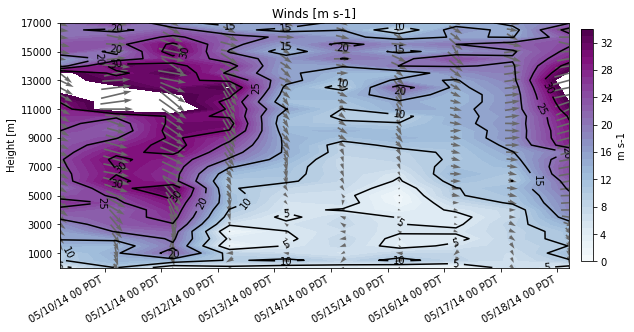

File saved as: /home/sbarc/students/coello/repos/research/chapter_one/old_scratch/radiosonde_profiles/figures/wind_radiosonde_time_profiles_2014_05_09_05:00:00_to_2014_05_18_05:00:00.png 



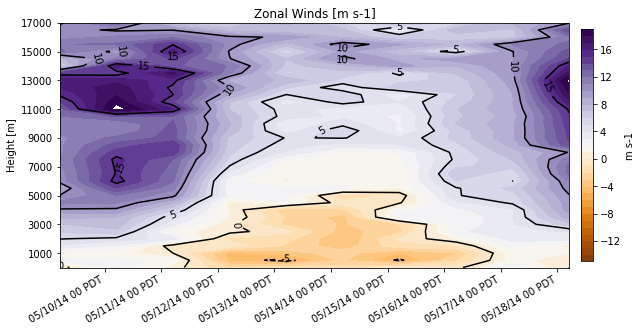

File saved as: /home/sbarc/students/coello/repos/research/chapter_one/old_scratch/radiosonde_profiles/figures/U_wind_radiosonde_time_profiles_2014_05_09_05:00:00_to_2014_05_18_05:00:00.png 



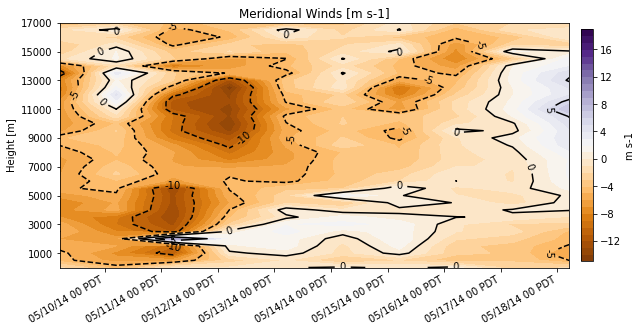

File saved as: /home/sbarc/students/coello/repos/research/chapter_one/old_scratch/radiosonde_profiles/figures/V_wind_radiosonde_time_profiles_2014_05_09_05:00:00_to_2014_05_18_05:00:00.png 



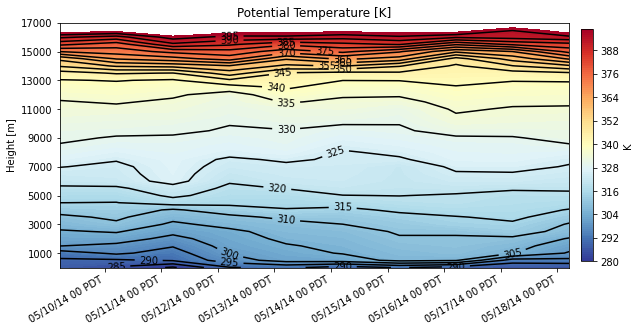

File saved as: /home/sbarc/students/coello/repos/research/chapter_one/old_scratch/radiosonde_profiles/figures/theta_radiosonde_time_profiles_2014_05_09_05:00:00_to_2014_05_18_05:00:00.png 



In [10]:
plot_radiosonde_profiles(time_grid, hght_grid, wspd, 0, 35, 'm s-1', 'Winds [m s-1]', 'wind', 'BuPu', \
                         U, V, outdir)

plot_radiosonde_profiles(time_grid, hght_grid, U, -15, 20, 'm s-1', 'Zonal Winds [m s-1]', 'U_wind', 'PuOr', \
                         None, None, outdir)

plot_radiosonde_profiles(time_grid, hght_grid, V, -15, 20, 'm s-1', 'Meridional Winds [m s-1]', 'V_wind', 'PuOr', \
                         None, None, outdir)

plot_radiosonde_profiles(time_grid, hght_grid, theta, 280, 400, 'K', 'Potential Temperature [K]', 'theta', 'RdYlBu_r', \
                         None, None, outdir)